# A study on sampled networkx with 5.3K nodes
The networkx is sampled using a random walk with flying back method
when Evaluating a sample, we want to do the following:
1. comapre basic properties including: average degree, average strength. Must include visulization testing power law on degree and strength
2. a clustering coef vs degree plot 

In [39]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
import random
import time
import utils
import re
from collections import defaultdict
import os
import seaborn as sns

In [2]:
G_sample = nx.read_edgelist('data/RWMult_sample5.3K.edgelist', data=(("total",float),("count", int)), create_using=nx.DiGraph)
# some basic properties
utils.print_basic_properties(G_sample)

Number of nodes: 5201
Number of edges: 33678
Average degree: 12.950586425687368
Average clustering coefficient: 0.01630735040785356


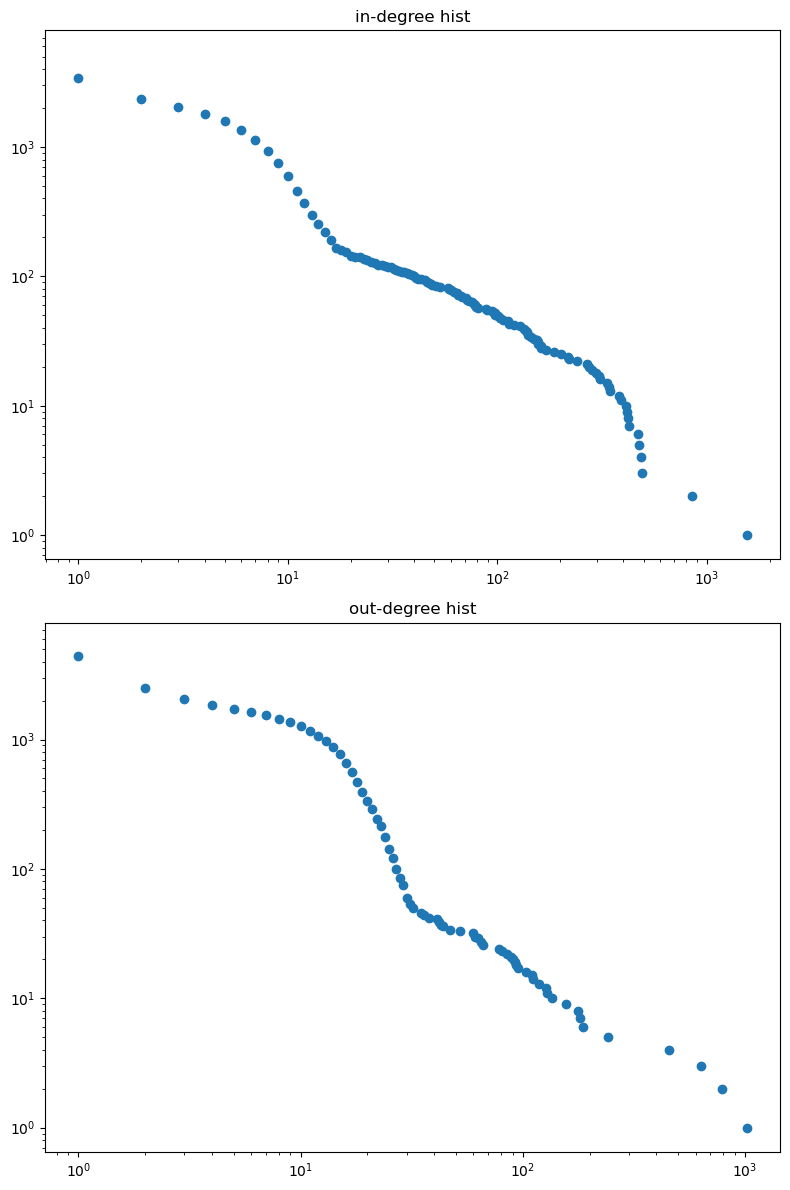

In [3]:
utils.degree_scatter(G_sample,['in','out'],type='count',log=True)

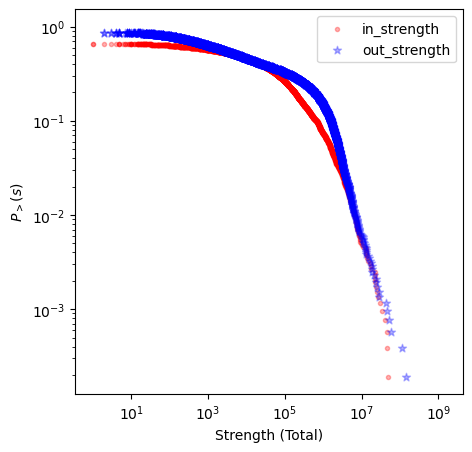

In [4]:
utils.strength_scatter(G_sample,figsize=(5,5))

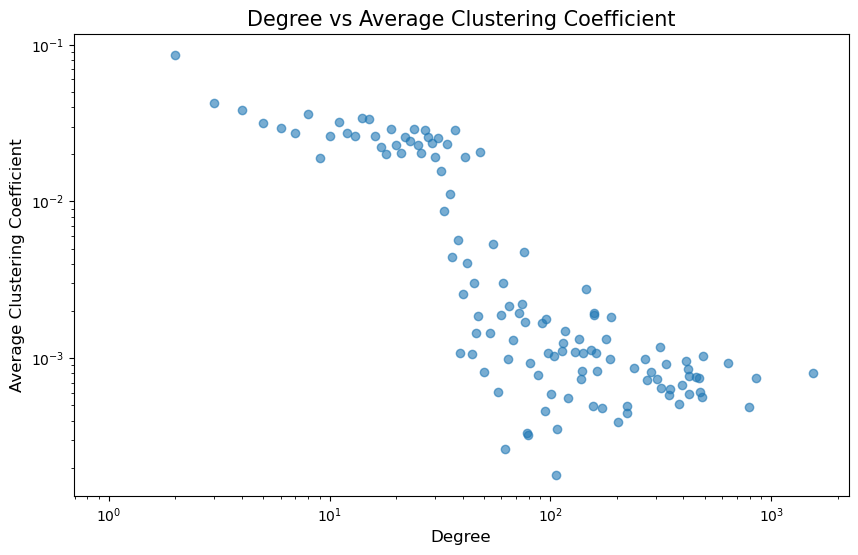

In [5]:
utils.degree_vs_avgclustering(G_sample)

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [7]:
def get_features(G):
    node_features = {}
    for node in G.nodes():
        in_edges = G.in_edges(node, data=True)
        out_edges = G.out_edges(node, data=True)
        
        in_degree = G.in_degree(node)
        out_degree = G.out_degree(node)
        
        in_strength_total = sum(data['total'] for _, _, data in in_edges)
        out_strength_total = sum(data['total'] for _, _, data in out_edges)
        
        in_strength_count = sum(data['count'] for _, _, data in in_edges)
        out_strength_count = sum(data['count'] for _, _, data in out_edges)
        
        clustering_coefficient = nx.clustering(G.to_undirected(), node)
        
        node_features[node] = [
            in_degree, 
            out_degree, 
            in_strength_total, 
            out_strength_total, 
            in_strength_count, 
            out_strength_count, 
            clustering_coefficient
        ]
    node_features_df = pd.DataFrame.from_dict(node_features,orient='index',
                                              columns=[
            'in_degree', 
            'out_degree', 
            "in_strength_total", 
            'out_strength_total', 
            'in_strength_count', 
            'out_strength_count', 
            "clustering_coefficient"
        ])
    return node_features_df

file_path = 'data/node_features.csv'
if os.path.exists(file_path):
    # Read the file
    node_feature_df = pd.read_csv(file_path)
    
else:
    # Create the file
    node_feature_df = get_features(G_sample)
    node_feature_df.to_csv(file_path, index=False)


In [14]:
node_feature_df.to_csv('data/node_features.csv',index=False)

## try different clsutersing in k means

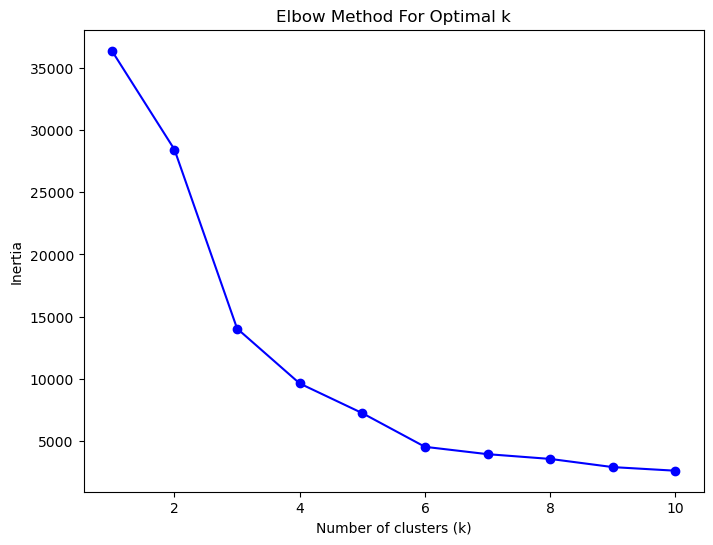

In [8]:
inertia = []
scaler = StandardScaler()
data = node_feature_df.values
normalized_features = scaler.fit_transform(data)
K = range(1, 11)  # Change range as needed

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [9]:

kmeans = KMeans(n_clusters=6)  # Change n_clusters to your desired number of clusters
kmeans.fit(data)
labels = kmeans.labels_
node_feature_df['cluster'] = labels



In [10]:
import seaborn as sns
from sklearn.manifold import Isomap

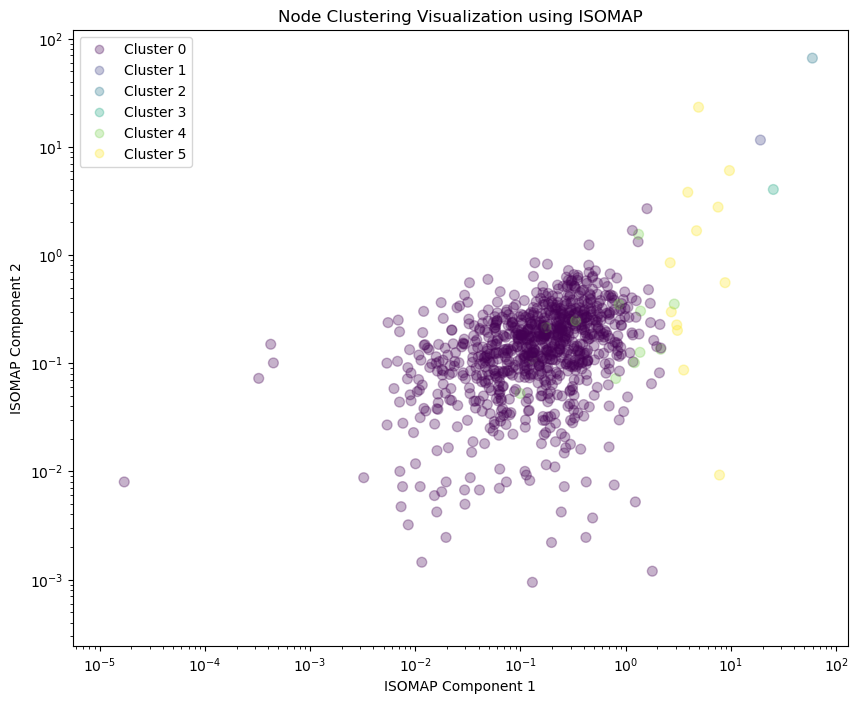

In [11]:
# Apply ISOMAP for dimensionality reduction
# isomap = Isomap(n_components=2)
# reduced_features = isomap.fit_transform(normalized_features)

# Scatter plot of the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(normalized_features[:,3], normalized_features[:,5], c=labels, cmap='viridis', s=50,alpha=0.3)
plt.title('Node Clustering Visualization using ISOMAP')
plt.xlabel('ISOMAP Component 1')
plt.ylabel('ISOMAP Component 2')
plt.xscale('log',base=10)
plt.yscale('log',base = 10)
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {i}' for i in range(6)])
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


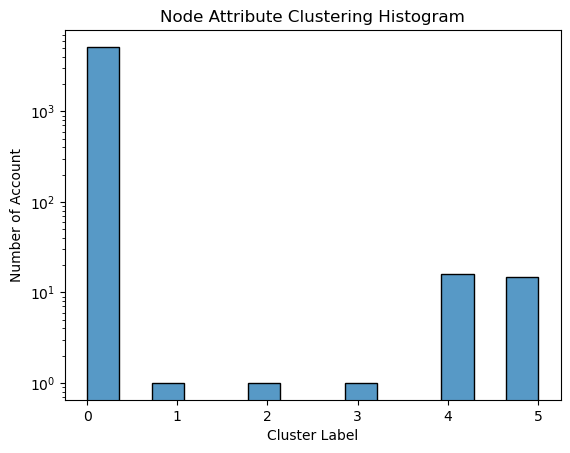

In [22]:
sns.histplot(node_feature_df,x='cluster',log_scale=(False,True))
#node_feature_df['cluster'].hist(log=True, grid=False)
plt.xlabel('Cluster Label')
plt.ylabel('Number of Account')
plt.title('Node Attribute Clustering Histogram')
plt.show()

Since we observed this very unbalanced cluster distribution, let's sample 150 nodes from cluster 1 and draw ths isomap again


In [31]:

indices_cluster_0 = np.where(labels == 0)[0]
sampled_indices_cluster_0 = np.random.choice(indices_cluster_0, size=150, replace=False)
indices_not_cluster_0 = np.where(labels != 0)[0]
final_indices = np.concatenate([sampled_indices_cluster_0, indices_not_cluster_0])
filtered_features =  normalized_features[final_indices]


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

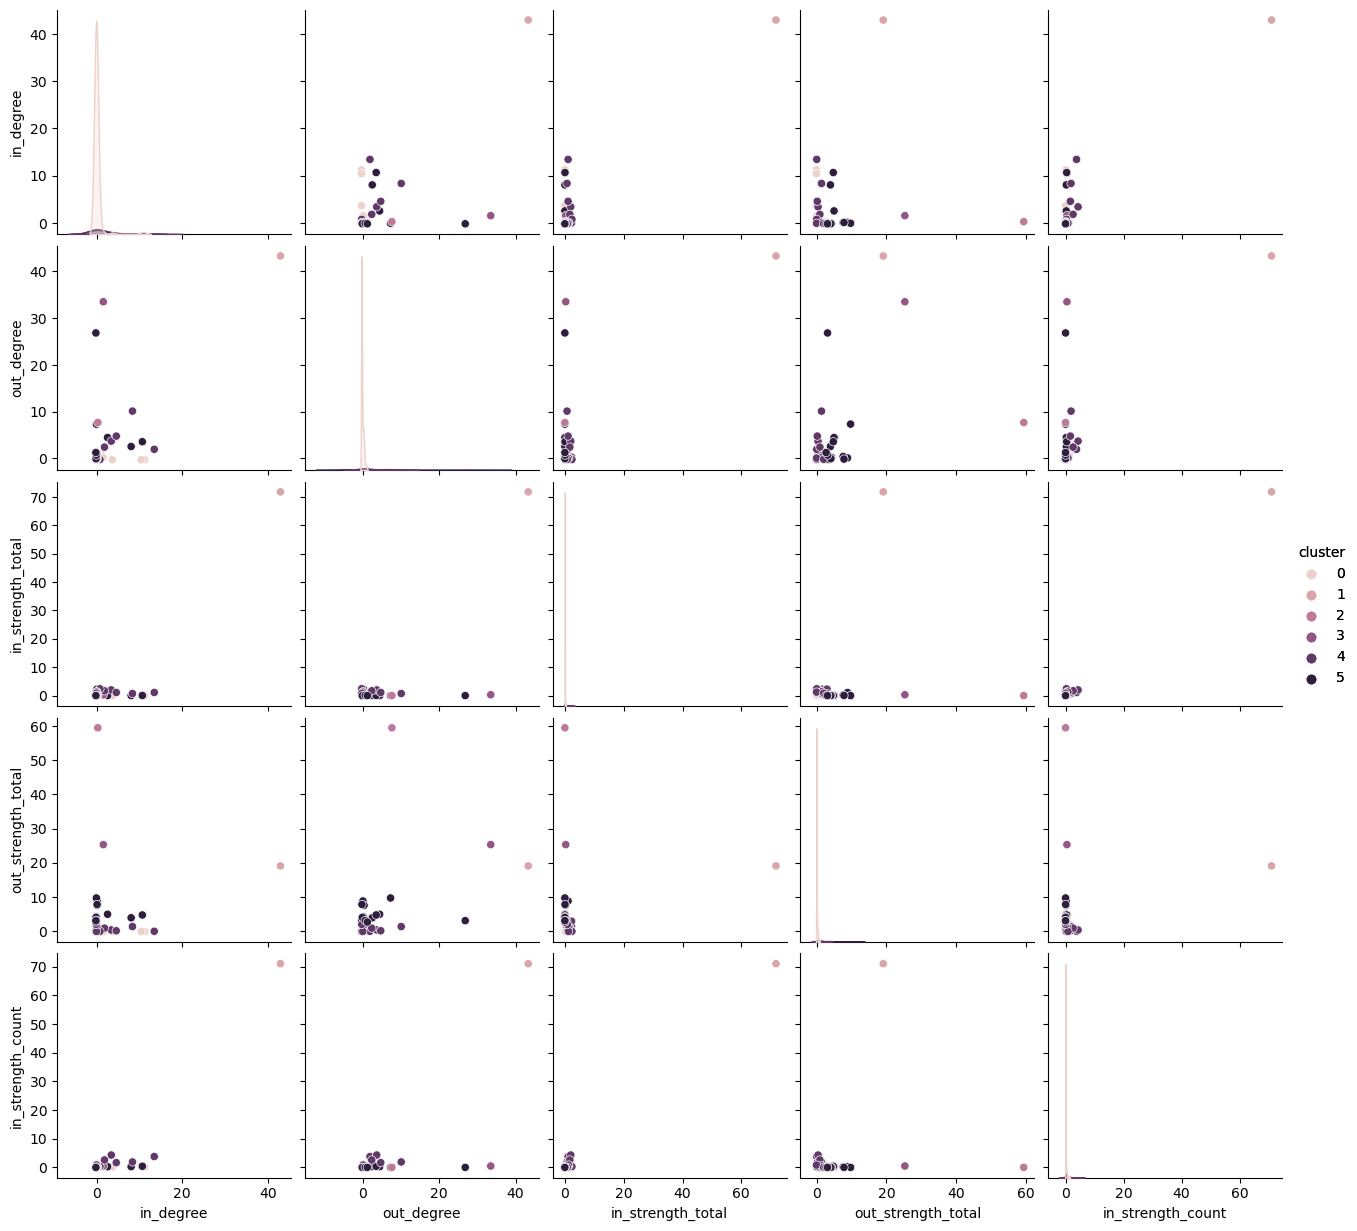

In [53]:
features = [
            'in_degree', 
            'out_degree', 
            "in_strength_total", 
            'out_strength_total', 
            'in_strength_count', 
            'out_strength_count', 
            "clustering_coefficient",
        ]
filtered_features_df = pd.DataFrame(filtered_features,columns=features)
filtered_labels = labels[final_indices]
filtered_features_df['cluster'] = filtered_labels
ax = sns.pairplot(filtered_features_df, vars=features[:5], hue='cluster')
ax.add_legend()
plt.show()

In [58]:
len(filtered_features)

184

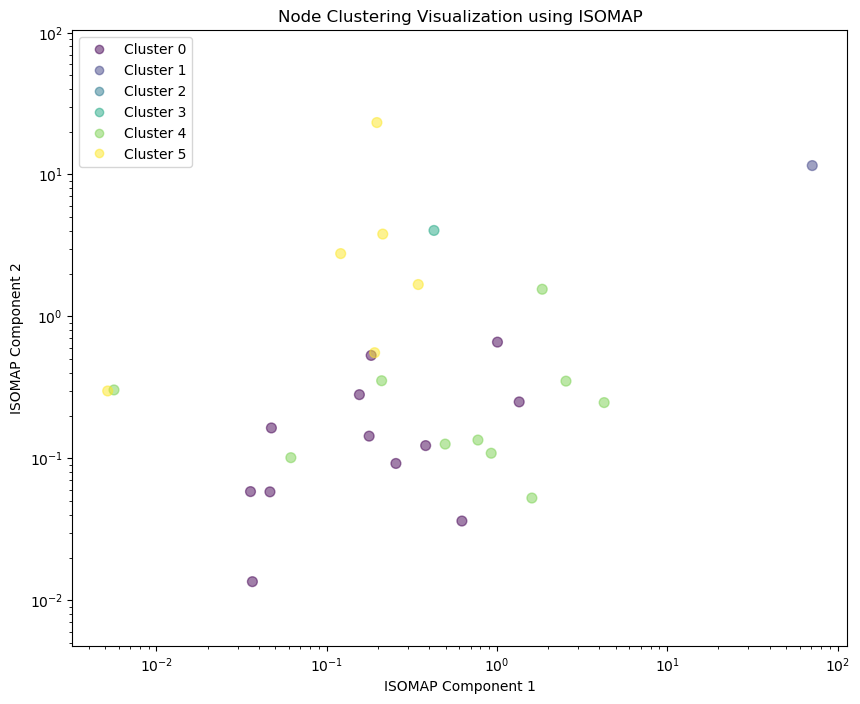

In [59]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(filtered_features[:,4], filtered_features[:,5], c=filtered_labels, cmap='viridis', s=50,alpha=0.5)
plt.title('Node Clustering Visualization using ISOMAP')
plt.xlabel('ISOMAP Component 1')
plt.ylabel('ISOMAP Component 2')
plt.xscale('log',base=10)
plt.yscale('log',base=10)
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {i}' for i in range(6)])

/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


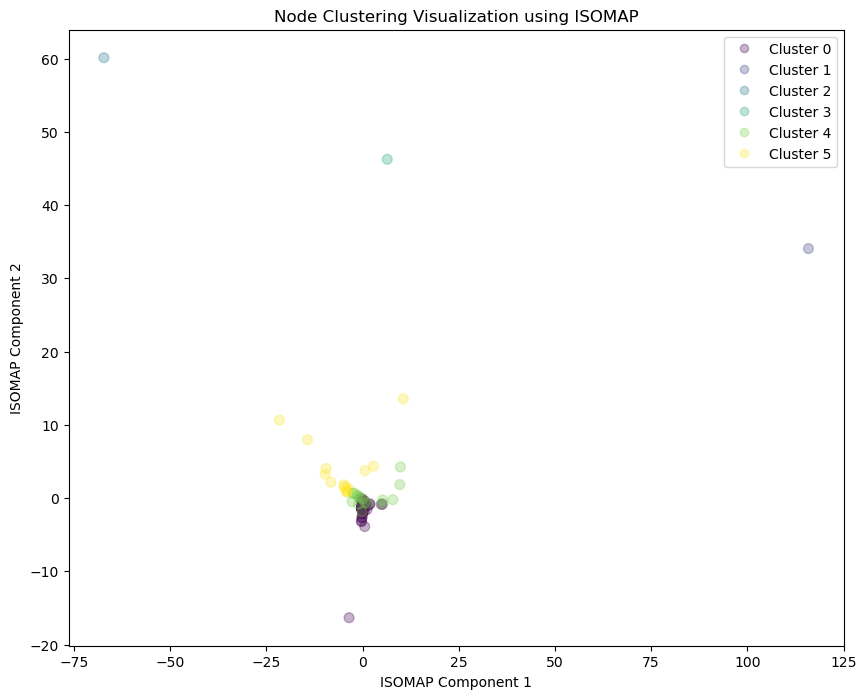

In [46]:
isomap = Isomap(n_components=2)
filtered_isomap = isomap.fit_transform(filtered_features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(filtered_isomap[:,0], filtered_isomap[:,1], c=labels[final_indices], cmap='viridis', s=50,alpha=0.3)
plt.title('Node Clustering Visualization using ISOMAP')
plt.xlabel('ISOMAP Component 1')
plt.ylabel('ISOMAP Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {i}' for i in range(6)])